In [1]:
import numpy as np
from numpy import linalg as LA
%matplotlib inline
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d.axes3d import Axes3D

from PIL import Image
from scipy.optimize import minimize
import f_class
from GP import GP
from GP_grad import GP_grad
from GD import GD
import time
import imageio
from utils import *
from torch.quasirandom import SobolEngine
import sobol_seq

#### Noiseless & Noisy

In [2]:
Noise = False # Specify if noisy or not
Noise_level = 0.00 # if noisy, what is the noise sd
'''If use the scaled X and y, rememeber to scale the noise as well'''

'If use the scaled X and y, rememeber to scale the noise as well'

#### High-dimensional function $f$

In [3]:
objective = f_class.sincos(Noise, Noise_level)
# objective = f_class.Branin(Noise, Noise_level)
# objective = f_class.Keane(Noise, Noise_level)
# objective = f_class.Rosenbrock_2(Noise, Noise_level)  
# objective = f_class.Griewank(Noise, Noise_level)
# objective = f_class.Alpine(Noise, Noise_level)
# objective = f_class.Shubert_2(Noise, Noise_level)
# objective = f_class.Ackley_2(Noise, Noise_level)
# objective = f_class.Schwefel(Noise, Noise_level)
# objective = f_class.Michalewicz(Noise, Noise_level)
# objective = f_class.Levy(Noise, Noise_level)
# objective = f_class.quad(Noise, Noise_level)
# objective = f_class.Eggholder(Noise, Noise_level)
# objective = f_class.Rastrigin(Noise, Noise_level, dim=2)


f = objective.func
clean_f = lambda x: f_class.sincos().func(x)
# clean_f = lambda x: f_class.Branin().func(x)
# clean_f = lambda x: f_class.Keane().func(x)
# clean_f = lambda x: f_class.Rosenbrock_2().func(x)
# clean_f = lambda x: f_class.Griewank().func(x)
# clean_f = lambda x: f_class.Alpine().func(x)
# clean_f = lambda x: f_class.Shubert_2().func(x)
# clean_f = lambda x: f_class.Ackley_2().func(x) 
# clean_f = lambda x: f_class.Schwefel().func(x)
# clean_f = lambda x: f_class.Michalewicz().func(x)
# clean_f = lambda x: f_class.Levy().func(x)
# clean_f = lambda x: f_class.quad().func(x)
# clean_f = lambda x: f_class.Eggholder().func(x)
# clean_f = lambda x: f_class.Rastrigin().func(x)



B = np.array([item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])], dtype=np.float64)
print(B) 
lb = B[:, 0]; ub = B[:, 1]
print(f( np.array([1, 1]) ))
# np.sin(np.array([2, 1]))

dim = objective.input_dim
print('dim: ', dim)

[[ 2. 10.]
 [ 2. 10.]]
[0.45464871]
dim:  2


In [4]:
x = np.array([1, 1]) 
f(x)

array([0.45464871])

#### Finding Optimized Hyperparameter $\sigma, \ell \rightarrow$ Online Update of Hyperparameter

In [5]:
# set seed
seed = 0
def random_draw(n_random_draws=3):
    """ samples some points"""
    # should draw randomly
    return np.random.uniform(lb, ub, size=(n_random_draws, dim))


def optimize_hyper(lb, ub, sample_size=2000):
#     np.random.seed(seed)
    X = np.asarray(np.random.uniform(lb, ub, size=(sample_size, dim)))
    gp.set_data(X, f(X))
    ls, var = gp.optimize()
    gp.clear()
    return (ls, var)

In [6]:
# # find optimized hyper, if online, skip this part
# gp = GP_grad(B, Noise, Noise_level)
# (ls, var) = optimize_hyper(lb, ub, sample_size=3000)
# del gp
# (ls, var)

##### Sampling

In [7]:
def unique_row(X):
    """
    A functions to trim repeated rows that may appear when optimizing.
    :param X: array to trim repeated rows from
    :return: mask of unique rows
    """
    # Sort array and kep track of where things should go back to
    order = np.lexsort(X.T)
    reorder = np.argsort(order)
    X = X[order]
    diff = np.diff(X, axis=0)
    U = np.ones(len(X), 'bool')
    U[1:] = (diff != 0).any(axis=1)
    return U[reorder]

class close_data():
    def __init__(self, Xc, eps=1):
        self.Xc = Xc
        self.eps = eps
        
    # Iterable
    def __iter__(self):
        return self
    
    # Iterator
    def __next__(self):
        Xn = self.Xc + self.eps*np.random.uniform(-1, 1, self.Xc.shape)
        return Xn
    
def is_new(Xn, Xpast=None):
    if Xpast is None:
        return True
    else:
        return np.array([(i != Xn).any() for i in Xpast]).all()

    
def close_draw(Xc, n_random_draws=4, close=1, Xpast=None):
    # sample from a small 2d box with center given Xc, no repeated points
    X = np.zeros((n_random_draws, dim))
    X[0] = Xc
    counter = 0
    gc = close_data(Xc)
    while True:
        Xn = next(gc)
        if LA.norm(Xn - Xc) > 5e-2 and is_new(Xn, Xpast) == True:
            counter += 1
            X[counter] = Xn
        if counter == n_random_draws-1:
            break
    return X

#### Grid & Plot

In [8]:
# creating meshgrid to plot over entire range
n_Grid = 100
x1 = np.linspace(lb[0], ub[0], n_Grid)
x2 = np.linspace(lb[1], ub[1], n_Grid)

X1, X2 = np.meshgrid(x1, x2)
Grid = np.vstack((X1.flatten(), X2.flatten())).T
Grid.shape

(10000, 2)

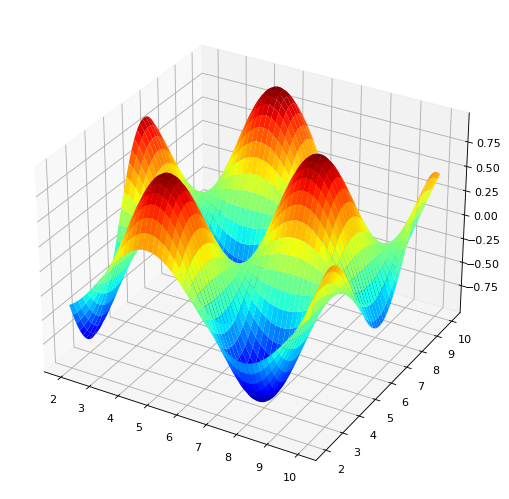

(10000,)

In [9]:
# 3d plot of the test function
from numpy import arange
from numpy import meshgrid
from matplotlib import pyplot
from matplotlib.pyplot import figure
# compute targets
results = f(Grid).reshape(X1.shape)
# create a surface plot with the jet color scheme
figure = pyplot.figure(figsize=(14, 8), dpi=80)
axis = figure.gca(projection='3d')
axis.plot_surface(X1, X2, results, cmap='jet')
# show the plot
pyplot.show()
f(Grid).shape

In [10]:
# 3d plot of the gradient
# approximate the gradient
from scipy import optimize

# optimize.approx_fprime(x, clean_Ackley_1d, eps)
eps = np.sqrt(np.finfo(float).eps)
approx_grad = np.array([optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid])
approx_grad.shape
g1 = approx_grad[:, 0]
g2 = approx_grad[:, 1]
g1, g2

(array([0.17317819, 0.20315769, 0.2318113 , ..., 0.76831894, 0.73859015,
        0.70404103]),
 array([-0.8268218 , -0.79357911, -0.75515721, ..., -0.21864957,
        -0.25814665, -0.29595897]))

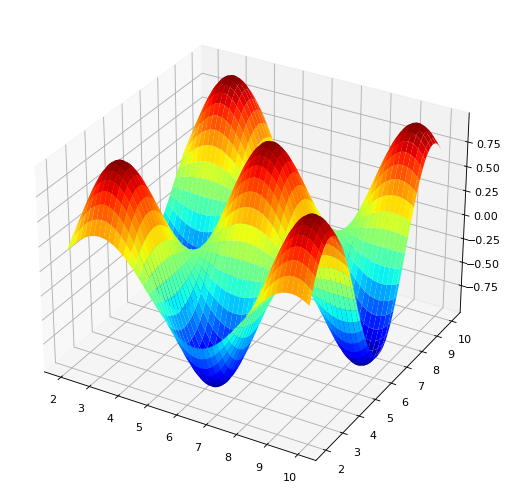

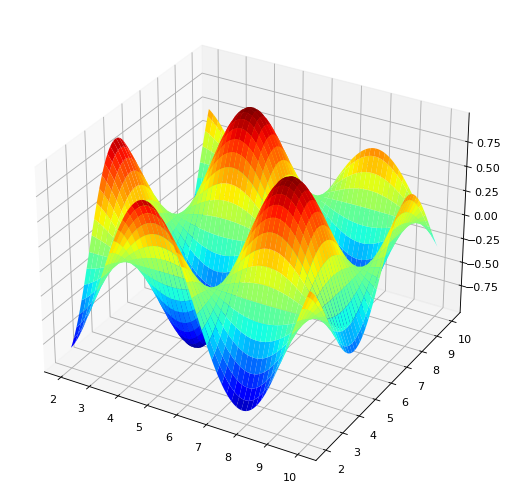

In [11]:
# create a surface plot with the jet color scheme
figure = pyplot.figure(figsize=(14, 8), dpi=80)
axis = figure.gca(projection='3d')
axis.plot_surface(X1, X2, g1.reshape(X1.shape), cmap='jet')
# show the plot
pyplot.show()

# create a surface plot with the jet color scheme
figure = pyplot.figure(figsize=(14, 8), dpi=80)
axis = figure.gca(projection='3d')
axis.plot_surface(X1, X2, g2.reshape(X1.shape), cmap='jet')
# show the plot
pyplot.show()

# *BO Test*

In [12]:
MAX = 200 # function observations

## GD

#### Set up

In [13]:
# initial data
setup = 1
X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))
# w = X[np.argmin(f(X))].reshape(1, dim)

# # sample from a small 2d box
# Xc = np.asarray(np.random.uniform(lb, ub, size=(1, dim)))
# X = close_draw(Xc, n_random_draws=setup)
# X_fix = X

In [14]:
gp = GP_grad(B, Noise, Noise_level, compress=False)
# gp.set_hyper(ls, var) # if online, skip

gp.set_data(X, f(X))

gp.optimize()
gp.fit()

history_w = []
history_full_w = []
history_f = []

##### warm up with UCB

In [15]:
# warmup = 3
# history_warmup = []
# for i in range(1, warmup+1):
#     b = np.log(i)
#     w, fw = gp.ucb_minimize(b)
#     X = np.vstack([X, w])
    
#     print(i, end = ', ')
#     print('w: ', w, end = ', ')
#     print('f(w): ', f(w).item(), end = ', ')
#     print()
    
#     gp.add_data(w.reshape(1, dim), f(w))
    
#     if i % 5 == 0:
#         ls, var = gp.optimize()
#         print('  # Optimal (ls, var) = ', (ls, var))
#     gp.fit()
#     history_warmup.append( (w, f(w)) )
    
# X_fix = X

##### warm up with TS

In [ ]:
warmup = 3
history_warmup = []
for i in range(1, warmup+1):
    w = gp.Thompson_sample()    
    X = np.vstack([X, w])
    
    print(i, end = ', ')
    print('w: ', w, end = ', ')
    print('f(w): ', f(w).item(), end = ', ')
    print()
    
    gp.add_data(w.reshape(1, dim), f(w))
    
    if i % 3 == 0:
        ls, var = gp.optimize()
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    history_warmup.append( (w, f(w)) )
    
X_fix = X

In [ ]:
# # fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(20, 12))
# x = Grid[:,0]
# y = Grid[:,1]

# # Posterior
# mu, covar = gp.posterior(Grid)
# mu = np.squeeze(mu)
# s = np.sqrt(np.diag(covar))

# fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(25, 8))

# # plot function
# im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
# fig.colorbar(im, ax=ax2)

# im1 = ax1.contour(X1, X2, clean_f(Grid).reshape(X1.shape),  cmap="PuBuGn") 
# im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")
# # im2 = ax1.contour(X1, X2, clean_f(Grid).reshape(X1.shape), cmap="YlOrRd")

# pl.clabel(im1, inline=True, fontsize=8)

# fig.colorbar(im1, ax=ax1)
# fig.colorbar(im2, ax=ax1)

# ax1.plot(np.squeeze(gp.X[:, 0]), np.squeeze(gp.X[:, 1]), 'ko', linewidth=2)

# ax1.title.set_text("Noisy Ackley via posterior derivative mean")
# ax2.title.set_text("Standard deviation")
# pl.show()

In [ ]:
# pl.figure(figsize=(13, 8), dpi=80)
# pl.plot(np.squeeze(np.array(history_warmup)[:, 1]), "-^")
# pl.xlabel("cost")
# pl.ylabel("function value")
# pl.grid(True)

##### optimize with GD

In [ ]:
w = gp.X[np.argmin(gp.y)]
optimizer = GD(gp, B, w, f)

In [ ]:
gp.posterior(w), f(w)
# gp.grad_sample(w), optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps)

In [ ]:
optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps)

In [ ]:
gp.optimize()
np.set_printoptions(precision=4)
stall = False
cost = setup + warmup
desc = -optimizer._grad()

lr_const = 0.01
lr = lr_const
while cost <= MAX:
    # update w 
    lr = lr_const
    if optimizer.contFail >= optimizer.stop or stall:
        print()
        print('New Local Search---------- ',)
        print('Fail = ', optimizer.contFail, end = ', ')
        print('Norm = ', LA.norm(desc))
        
        # random draw
        w = np.asarray(np.random.uniform(lb, ub, size=(1, dim)))

        # UCB draw
#         w, _ = gp.ucb_minimize(cost)
                    
        # many UCB draws
        
         # many UCB draws, pick the best
#         history_warmup = []
#         alternate = 5
#         for i in range(1, alternate+1):
#             b = np.log(i)
#             w, fw = gp.ucb_minimize(b)
#             X = np.vstack([X, w])

# #             print(i, end = ', ')
# #             print('w: ', w, end = ', ')
# #             print('f(w): ', f(w).item(), end = ', ')
# #             print()

#             gp.add_data(w.reshape(1, dim), f(w))
#             if i % 5 == 0:
#                 ls, var = gp.optimize()
#                 print('  # Optimal (ls, var) = ', (ls, var))
#             gp.fit()
#             history_warmup.append( (w, f(w)) )

#         w = X[np.argmin(f(X))]
        
        # Thompson Sampling draw      posterior of GP given gp.X, gp.y
#         w = gp.Thompson_sample()
        
        if is_new(w, gp.X) == False:
            raise ValueError('  ? hit past points')
        
        gp.add_data(w.reshape(1, -1), f(w))
        
        # change back setting
        stall = False
        history_w.append(optimizer.history_w)
        history_f.append([f(w).item() for w in optimizer.history_w])
        optimizer = GD(gp, B, w, f)
        cost += 1
    else:
        lr = lr*1
        w, desc = optimizer.update_bfgs(y_best=np.min(f(gp.X)), lr=lr)
    
        if is_new(w, gp.X) == False:
            print('  ** hit past points')
            stall = True
            continue
            
        gp.add_data(w.reshape(1, -1), f(w))
        cost += 1
        
    # online hyper udpate + fitting GP with new query w
    if cost % 3 == 0:
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    
    m, v = gp.posterior_full_grad('full', dim*[w])
    v = np.sqrt(np.diag(v))
    print(cost, end = '. ')
    print('    w: ', np.squeeze(w), end = ', ')
    print('    f(w): %.6f ' % f(w).item())
    print('     d(w): ', np.squeeze(m), end = ', ')
    print('    s.d: ', np.squeeze(v), end = ', ')
    print('    g(w):', optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps))
    print()
        
print('Max Cost reached = ', cost)
history_w.append(optimizer.history_w)
history_f.append([f(w).item() for w in optimizer.history_w])

In [ ]:
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(20, 12))
x = Grid[:,0]
y = Grid[:,1]

# Posterior
mu, covar = gp.posterior(Grid)
mu = np.squeeze(mu)
s = np.sqrt(np.diag(covar))

fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(25, 8))

# plot function
im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
fig.colorbar(im, ax=ax2)

im1 = ax1.contour(X1, X2, clean_f(Grid).reshape(X1.shape),  cmap="PuBuGn") 
im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")

pl.clabel(im1, inline=True, fontsize=8)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax1)

for lw in history_w:
    array_w = np.vstack(lw)
    ax1.plot(array_w[:, 0], array_w[:, 1], 'o-', linewidth=1, markersize=8)
    ax1.plot(array_w[0][0], array_w[0][1], "r^", markersize=12, alpha=0.5)
    ax1.plot(array_w[-1][0], array_w[-1][1], "bs", markersize=12, alpha=0.5)


UCBwarmup = np.vstack([point[0] for point in history_warmup])
ax1.plot(UCBwarmup[:, 0], UCBwarmup[:, 1], 'ko', linewidth=2)
# ax1.title.set_text("Noisy Ackley via posterior derivative mean")
# ax2.title.set_text("Standard deviation")

# plot derivative
#     p1 = y*np.cos(y)* ( (2*x*np.cos(x)) - np.sin(x) ) / (2* (x*y)**(3/2))
#     p2 = - x*np.sin(x)* ( (2*y*np.sin(y)) + np.cos(y) ) / (2* (x*y)**(3/2))
#     p1 = np.cos(x)*np.cos(y)
#     p2 = -np.sin(x)*np.sin(y)

#     im = ax4.pcolormesh(X1, X2, s_grad_1.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax4)
#     im1 = ax3.contour(X1, X2, p1.reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax3.contour(X1, X2, mu_grad_1.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax3)
#     fig.colorbar(im2, ax=ax3)

#     ax3.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax3.plot(w[0], w[1], "ro", markersize=5, alpha=0.8)
#     ax3.title.set_text("Mean of Posterior Partial x")
#     ax4.title.set_text("Std of Posterior Partial x")

#     im3 = ax6.pcolormesh(X1, X2, s_grad_2.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im3, ax=ax6)
#     im4 = ax5.contour(X1, X2, p2.reshape(X1.shape), cmap="PuBuGn")
#     im5 = ax5.contour(X1, X2, mu_grad_2.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im4, ax=ax5)
#     fig.colorbar(im5, ax=ax5)

#     ax5.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax5.plot(w[0], w[1], "ro", markersize=5, alpha=0.8)
#     ax5.title.set_text("Mean of Posterior Partial y")
#     ax6.title.set_text("Std of Posterior Partial y")
# Saving all the plots in 2D_Plots (need to creat a folder) 
pl.show()

In [ ]:
pl.figure(figsize=(13, 8), dpi=80)
axis = 1
for l in history_f:
    pl.plot(np.arange(axis, axis+len(l)), l, "-o", markersize=2)
    pl.plot(axis, l[0], "r^", markersize=8)
    pl.plot(axis+len(l)-1, l[-1], "ks")
    axis += len(l) + setup # COST includes setup

pl.plot()

pl.xlabel("Cost")
pl.ylabel("function value")
pl.grid(True)

## Minima of GD

In [ ]:
gp.X[np.argmin(gp.y)], np.min(gp.y), np.argmin(gp.y)

In [ ]:
gp.get_hyper()

In [ ]:
# # only for backtracking
# pl.figure(figsize=(10, 6), dpi=80)
# # pl.plot(history_lr, "-^")
# pl.title("learning rate as the algorithm runs")
# pl.xlabel("n_iter")
# pl.ylabel("learning rate")
# pl.yscale("log")
# pl.grid(True)

### *UCB*

In [ ]:
### Thompson Sampling
import os
gp.clear()
# gp.set_hyper(ls, var) # if online update hyper, skip

# init cost
X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))
X = X_fix

gp.set_data(X, f(X))
gp.optimize()
gp.fit()

history = []

In [ ]:
mesh = np.random.uniform(gp.B[:, 0], gp.B[:, 1], size=(1000, gp._B.shape[0]))
mesh[0].shape

In [ ]:
cost = setup + warmup
while cost < MAX:
    # 1. Thompson Sampling
    w = gp.Thompson_sample()
    
    # 2. GP_UCB/EI
#     b = np.log(cost)
#     arg_min = np.argmin(mu.reshape(-1,1) - np.sqrt(b)*s.reshape(-1, 1)) # discrete version
#     w = Grid[arg_min]
#     w, fw = gp.ucb_minimize(b)
#     w, fw = gp.EI_minimize(y_best=np.min(f(gp.X)))
    if is_new(w, gp.X) == False:
        print('visit before, ignore ', w)
        continue
    
    
#     fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(24, 21))

#     # plot function (ax1, ax2)
#     im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax2)

#     im1 = ax1.contour(X1, X2, functions.Ackley_2().func(Grid).reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax1)
#     fig.colorbar(im2, ax=ax1)

#     ax1.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax1.plot(w[0], w[1], 'ro')
#     ax1.title.set_text("Noisy Ackley")
#     ax2.title.set_text("Standard Deviation")
    
    
#     # plot derivative in (ax3, ax4), (ax5, ax6)
#     im = ax4.pcolormesh(X1, X2, s_grad_1.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax4)
#     im1 = ax3.contour(X1, X2, g1.reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax3.contour(X1, X2, mu_grad_1.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax3)
#     fig.colorbar(im2, ax=ax3)

#     ax3.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax3.title.set_text("Mean of Posterior Partial x")
#     ax4.title.set_text("Std of Posterior Partial x")

    
#     im3 = ax6.pcolormesh(X1, X2, s_grad_2.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im3, ax=ax6)
#     im4 = ax5.contour(X1, X2, g2.reshape(X1.shape), cmap="PuBuGn")
#     im5 = ax5.contour(X1, X2, mu_grad_2.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im4, ax=ax5)
#     fig.colorbar(im5, ax=ax5)

#     ax5.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax5.title.set_text("Mean of Posterior Partial y")
#     ax6.title.set_text("Std of Posterior Partial y")

#     filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
#     pl.savefig('2D_Plots/Ackley/' + filename)
#     pl.show()  
    print(cost, end = ', ')
    print('w: ', w, end = ', ')
    print('f(w): ', f(w).item(), end = ', ')
    print()
    
    history.append( (w, f(w)) )
    gp.add_data(w.reshape(1, dim), f(w))
    
    if cost % 4 == 0:
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    cost += 1

In [ ]:
Grid[arg_min] 

In [ ]:
pl.figure(figsize=(13, 8), dpi=80)
pl.plot(np.squeeze(np.array(history)[:, 1]), "-^")
pl.xlabel("cost")
pl.plot(np.minimum.accumulate(np.array(history)[:, 1]), 'r', lw=1)
pl.ylabel("function value")
pl.grid(True)

In [ ]:
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(20, 12))
# Posterior
mu, covar = gp.posterior(Grid)
mu = np.squeeze(mu)
s = np.sqrt(np.diag(covar))

fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(25, 8))

# plot function
im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
fig.colorbar(im, ax=ax2)

im1 = ax1.contour(X1, X2, clean_f(Grid).reshape(X1.shape),  cmap="PuBuGn") 
im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")
# im2 = ax1.contour(X1, X2, clean_f(Grid).reshape(X1.shape), cmap="YlOrRd")

pl.clabel(im1, inline=True, fontsize=8)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax1)

ax1.plot(np.squeeze(gp.X[:, 0]), np.squeeze(gp.X[:, 1]), 'ko', linewidth=2)

ax1.title.set_text("Noisy Ackley via posterior derivative mean")
ax2.title.set_text("Standard deviation")
pl.show()

## Global Minima 

In [ ]:
gp.X[np.argmin(gp.y)], np.min(gp.y)

In [ ]:
gp.get_hyper()